In [27]:
import umap
import math
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning
from scipy.stats import binom_test

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict

from contrastive.evaluation.train_multiple_classifiers import compute_auc

In [28]:
# test model
test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/chosen_model/chosen_model"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#2"
dataset_train = 'cingulate_HCP_half_2_NEOFAC_C'

# load the data
train_df = pd.read_csv(test_model+'/'+dataset_train+'_embeddings/train_val_embeddings.csv', index_col=0)
train_df.sort_index(inplace=True)

In [29]:
dataset_test = 'cingulate_HCP_half_1_gender'

test_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
test_df.sort_index(inplace=True)

# load the labels
prediction_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
prediction_df.sort_index(inplace=True)
len(prediction_df)

549

In [30]:
prediction_df.head()

,label,predicted_0,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6,predicted_7,predicted_8,...,predicted_243,predicted_244,predicted_245,predicted_246,predicted_247,predicted_248,predicted_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
100307,0,0.518107,0.608458,0.494703,0.541186,0.558439,0.610391,0.447737,0.500000,0.481827,...,0.484733,0.546079,0.490953,0.441781,0.500000,0.517211,0.526988,0.530140,0.531179,0.526778
100610,1,0.471508,0.417347,0.486048,0.454403,0.438434,0.415786,0.516109,0.485498,0.500000,...,0.492914,0.458829,0.489084,0.520918,0.479576,0.472838,0.468992,0.464367,0.462381,0.468770
101107,1,0.500000,0.551338,0.492119,0.515282,0.522602,0.552208,0.468025,0.493624,0.485840,...,0.487174,0.520060,0.490395,0.465228,0.500000,0.500000,0.509679,0.509841,0.510477,0.509465
101309,1,0.516081,0.600118,0.494326,0.537418,0.553228,0.601894,0.450680,0.500000,0.482412,...,0.485088,0.542294,0.490871,0.445178,0.500000,0.515282,0.524468,0.527253,0.528197,0.524257
102008,1,0.500000,0.537423,0.491491,0.508971,0.513862,0.538037,0.472983,0.492784,0.486816,...,0.487767,0.513720,0.490259,0.470967,0.500000,0.500000,0.505467,0.502546,0.505621,0.505251


## correlation functions

In [31]:
def get_model_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[aucs.index != 'label']
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [32]:
def cross_correlation(model_path, dataset='cingulate_ACCpatterns_1'):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    fig, axs = plt.subplots(1, 4, figsize=(30,10)) 

    latent_df = full_df.iloc[:,1:]
    corr = latent_df.corr()
    axs[0] = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[0]
            )

    latent_df = full_df[full_df.label == 0].iloc[:,1:]
    corr0 = latent_df.corr()
    axs[1] = sns.heatmap(
            corr0, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[1]
            )

    latent_df = full_df[full_df.label == 1].iloc[:,1:]
    corr1 = latent_df.corr()
    axs[2] = sns.heatmap(
            corr1, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[2]
            )

    corrdiff = (corr1-corr0)
    axs[3] = sns.heatmap(
            corrdiff, 
            vmin=corrdiff.min().min(), vmax=corrdiff.max().max(), center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[3]
            )


In [33]:
def visualize_each_variable(model_path, display: str, display_err: bool, normalize=True, verbose=False, dataset='cingulate_ACCpatterns_1'):
    '''
    display: str -> takes the values '0', '1', 'all'
    '''
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Chooses to display only labels '0', '1' or all
    if display == '0':
        full_df = full_df[full_df.label == 0]
    elif display == '1':
        full_df = full_df[full_df.label == 1]
    
    # Some prints if verbose true
    if verbose:
        print("Prediction df:")
        print(prediction_df.iloc[:2, :2])
        print(len(prediction_df))
        print(prediction_df[['label']].shape)
        print("Data df:")
        print(len(data_df))
        print(data_df.iloc[:2, :2])
        print(data_df.shape)
        print("Full df:")
        print(len(full_df))
        print(full_df.iloc[:2, :2])
        print(full_df.shape)

    N, D = full_df.shape
    D = D-1 # There is the label column added

    # Initializes plot
    plt.figure(figsize=(16,12))

    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, N, axis=0)

    # Replaces labels 0, 1 with colors
    label_df = full_df[['label']].copy()
    label_df['label'] = label_df['label'].astype("str")
    label_df['label'] = label_df['label'].replace('0', 'b')
    label_df['label'] = label_df['label'].replace('1', 'r')

    # Builds colors to match pyplot requirements
    colors = label_df['label'].values
    colors = np.reshape(colors, (1,N))
    colors = np.repeat(colors, D, axis=0)
    colors = colors.T
    print('x, full_df and colors shapes: ', x.shape, full_df.shape, colors.shape)
    colors = np.reshape(colors, (N*D,))

    # latent (doesn't take the first column, which is the label)
    latent_df = full_df.iloc[:,1:]
    mu = latent_df.mean()
    std = latent_df.std()
    if normalize == True:
        latent_df = (latent_df-mu)/std

    # Actual plotting of each point
    plt.scatter(x, latent_df, c=colors, marker='.')

    # Computes averages
    if display == "all":
        # Computes average for label=0
        x = np.arange(D)
        label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
        if normalize == True:   
            label0_df = (label0_df-mu)/std
        mean_df = label0_df.mean()
        e_df = label0_df.std()
        print(x.shape, mean_df.shape, e_df.shape)
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='blue', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3, solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

        # Computes average for label=1
        label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
        if normalize == True:   
            label1_df = (label1_df-mu)/std
        mean_df = label1_df.mean()
        e_df = label1_df.std()
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='red', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3,solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    # Shows the computed plot
    plt.show()

    return 

In [34]:
def full_visualization(model_path, dataset='cingulate_ACCpatterns_1'):
    plt.figure(figsize=(12.8, 9.6))
    fig = plt.imshow(mpimg.imread(model_path+"/"+dataset+"_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    plt.show()
    return visualize_umaps(model_path, dataset)

In [35]:
# test model
# visual_embs = full_visualization(test_model)

## Visualize each variable of the latent

x, full_df and colors shapes:  (171, 10) (171, 11) (171, 10)
(10,) (10,) (10,)


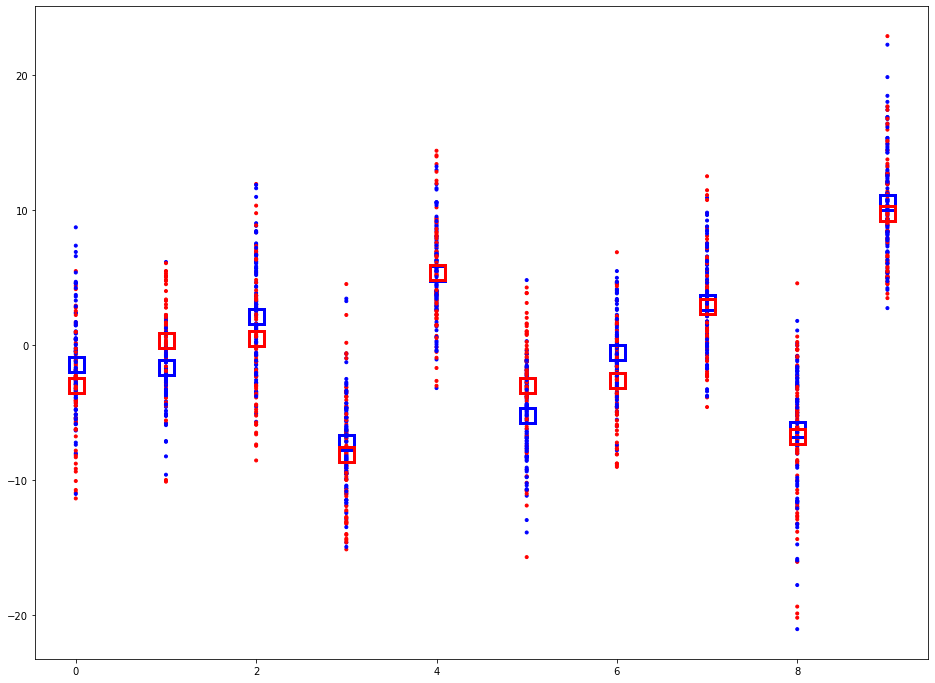

In [36]:
visualize_each_variable(test_model, display='all', display_err=False, normalize=False, verbose=False)

In [37]:
def do_pca(model_path, dataset=dataset_test):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Makes PCA over all dataframe
    latent_df = full_df.iloc[:,1:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = latent_df.shape[1]
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(latent_df_normalized)

    # Transforms over label0 dataframe
    label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
    label0_df = (label0_df - latent_df.mean()) / latent_df.std()
    transformed0 = pca.transform(label0_df)
    mean0 = np.mean(transformed0, axis=0)
    print(mean0.shape)

    # Transforms over label1 dataframe
    label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
    label1_df = (label1_df - latent_df.mean()) / latent_df.std()
    transformed1 = pca.transform(label1_df)
    mean1 = np.mean(transformed1, axis=0)
    print(mean1.shape)

    idx = np.arange(n_components)+1
    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

    limit_df = n_components

    #make scree plot
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    fig, axs = plt.subplots(1, 2, figsize=(30,10)) 
    [t.set_color('white') for t in axs[0].xaxis.get_ticklabels()]
    [t.set_color('white') for t in axs[0].yaxis.get_ticklabels()]
    axs[0].set_title('Explained variance across principal components', fontsize=14)
    axs[0].set_xlabel('Principal component', fontsize=12)
    axs[0].set_ylabel('Explained variance', fontsize=12)
    sns.barplot(ax=axs[0], x=idx[:limit_df], y='explained variance', data=df_explained_variance, palette='summer')
    axs[0] = axs[0].twinx()
    axs[0].grid(False)
    axs[0].set_ylabel('Cumulative', fontsize=14)
    sns.lineplot(ax=axs[0], x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance, color='#fc8d59')

    N, D = transformed.shape
    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs[1].scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs[1].scatter(x, transformed1, c='red', marker='.')
    x = np.arange(D)
    axs[1].plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)
    axs[1].plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()


In [38]:
def do_dictionary_learning(data_df, n_components=10, transform_n_nonzero_coefs=1):
    data_df_local = data_df.copy()
    full_df_local = pd.DataFrame()
    # Makes dictionary learning over all embeddings
    latent_df = data_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = n_components
    dict_learner = DictionaryLearning(n_components=n_components,
                                      transform_n_nonzero_coefs=transform_n_nonzero_coefs,
                                      alpha=1)
    transformed = dict_learner.fit_transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = data_df_local.index
    full_df_local = pd.merge(data_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local, dict_learner

In [39]:
def plot_patterns(prediction_df, transformed_df, random=False):
    # Makes local copy
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)
    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Transforms over label0 dataframe
    label0_df = full_df_local[full_df_local['label'] == 0].iloc[:,1:]
    transformed0 = label0_df.values

    # Transforms over label1 dataframe
    label1_df = full_df_local[full_df_local['label'] == 1].iloc[:,1:]
    transformed1 = label1_df.values

    fig, axs = plt.subplots(1, 1, figsize=(10,7)) 

    _, D = transformed0.shape

    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs.scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs.scatter(x, transformed1, c='red', marker='.')

    x = np.arange(D)

    masked0 = np.ma.masked_equal(transformed0, 0.)
    mean0 = masked0.mean(axis=0)
    axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    masked1 = np.ma.masked_equal(transformed1, 0.)
    mean1 = masked1.mean(axis=0)
    axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()

In [40]:
def return_predictions(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res = np.zeros(2*n_patterns)

    # Makes random permutation to produce random label
    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)

    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df_local[full_df_local[c] < 0.]
        res[2*i] = df['label'].mean()
        df = full_df_local[full_df_local[c] > 0.]
        res[2*i+1] = df['label'].mean()

    return res

def plot_predictions(prediction_df, transformed_df):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_random = np.zeros((20, 2*n_patterns))

    # Loads labels
    mean_label = prediction_df_local['label'].mean()
    print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res = return_predictions(prediction_df_local, transformed_df_local)
    for i in range(20):
        res_random[i,:] = return_predictions(prediction_df_local, transformed_df_local, True)
    
    for i in range(20):
        plt.scatter(x, res_random[i], c='grey')

    plt.scatter(x, res, c='red')
    plt.plot(mean_label*np.ones(2*n_patterns))
    plt.ylim((0,1))
    return res   

In [41]:
def return_sum(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res_sum = np.zeros(2*n_patterns)
    res_len = np.zeros(2*n_patterns)

    full_df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df[full_df[c] < 0.]
        res_sum[2*i] = df['label'].sum()
        res_len[2*i] = len(df)
        df = full_df[full_df[c] > 0.]
        res_sum[2*i+1] = df['label'].sum()
        res_len[2*i+1] = len(df)

    return res_sum, res_len


def do_t_test(prediction_df, transformed_df, show=True, nb_components=10):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_p = np.zeros(2*n_patterns)

    # Mean labels
    mean_label = prediction_df_local['label'].mean()
    # print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res_sum, res_len = return_sum(prediction_df_local, transformed_df_local)
    
    for i in range(2*n_patterns):
        res_p[i] = binom_test(res_sum[i], n=res_len[i], p=mean_label, alternative='two-sided')

    if show:
        plt.scatter(x, -np.log10(res_p))
        plt.plot(-np.log10(0.05/(2*nb_components))*np.ones(2*n_patterns))

    return res_p   

In [42]:
def give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, show=True, nb_components=10):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)
    nb_subjects = np.zeros(len(res_p))
    nb_subjects_relevant = 0
    exact_nb_subjects_relevant = 0
    log_p_nb_subjects = 0
    max_auc_score = 0.0
    auc_score = np.zeros(len(res_p))
    # print(len(df.columns))
    for i in range(1,len(df.columns)):
        # print(df.iloc[:,[i]].columns)
        d = df[df.iloc[:,i] < 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        # print(np.unique(d.label.values).shape)
        nb_subjects[2*i-2] = len(d)
        auc_score[2*i-2] = accuracy_score(d.label, d.iloc[:,i])
        if 2.*d.label.sum() < (len(d.label)):
            exact_nb_subjects = len(d.label)-d.label.sum()
        else:
            exact_nb_subjects = d.label.sum()
        
        if res_p[2*i-2] < 0.05/nb_components:
            nb_subjects_relevant += nb_subjects[2*i-2]
            max_auc_score = max(auc_score[2*i-2], max_auc_score)
            exact_nb_subjects_relevant += exact_nb_subjects
            log_p_nb_subjects += -np.log10(res_p[2*i-2])*exact_nb_subjects

        d = df[df.iloc[:,i] > 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        nb_subjects[2*i-1] = len(d)
        auc_score[2*i-1] = accuracy_score(d.label, d.iloc[:,i])
        if 2.*d.label.sum() < (len(d.label)):
            exact_nb_subjects = len(d.label)-d.label.sum()
        else:
            exact_nb_subjects = d.label.sum()
        
        if res_p[2*i-1] < 0.05/nb_components:
            nb_subjects_relevant += nb_subjects[2*i-1]
            max_auc_score = max(auc_score[2*i-1], max_auc_score)
            exact_nb_subjects_relevant += exact_nb_subjects
            log_p_nb_subjects += -np.log10(res_p[2*i-2])*exact_nb_subjects
            
    # print(d)
    if show:
        x = np.arange(len(res_p))
        plt.scatter(x, auc_score)
        plt.ylabel('accuracy_score')
        # plt.scatter(res_p, auc_score)
        # plt.xlabel('p value')
        # plt.ylabel('auc_score')
    return nb_subjects_relevant, max_auc_score, exact_nb_subjects_relevant, log_p_nb_subjects

In [43]:
def test_dictionary_learning(dict_learner, test_df, n_components):
    test_df_local = test_df.copy()
    full_df_local = pd.DataFrame()
    latent_df = test_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    transformed = dict_learner.transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = test_df_local.index
    full_df_local = pd.merge(test_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local


## Non-zeros=1, nb_components=4

In [44]:
full_df, transformed_train_df, dict_learner = do_dictionary_learning(data_df=train_df, n_components=4, transform_n_nonzero_coefs=1)

In [45]:
full_df, transformed_df = test_dictionary_learning(dict_learner=dict_learner, test_df=test_df, n_components=4)

In [46]:
dict_learner.components_

array([[-0.21185369,  0.46467701, -0.18048735, -0.4818397 ,  0.01153796,
         0.15896408, -0.2441136 , -0.2193248 ,  0.43762107, -0.38708964],
       [-0.41511192, -0.01686249,  0.52224201, -0.30374645,  0.17525728,
        -0.19102198,  0.11543515,  0.27666442,  0.53428387,  0.14094996],
       [-0.19446737,  0.34951643,  0.03611421, -0.31079097, -0.20594686,
         0.68988659, -0.22620195, -0.39695522,  0.07577726,  0.09635798],
       [-0.03269238,  0.1307042 ,  0.36371684, -0.10255772,  0.47405379,
        -0.09771276,  0.43010918,  0.36135563, -0.02768688,  0.53705349]])

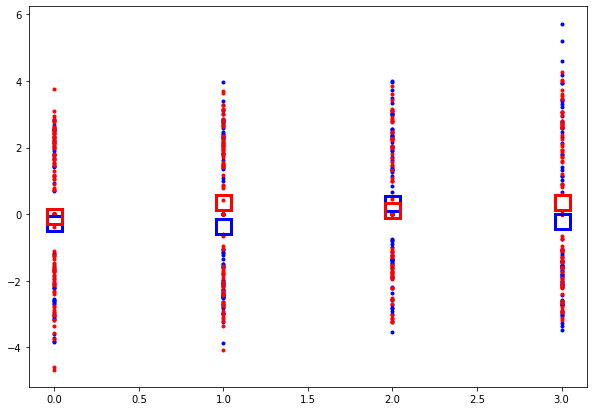

In [47]:
plot_patterns(prediction_df, transformed_df, random=False)

In [48]:
# plot_patterns(prediction_df, transformed_df, random=True)

In [49]:
def plot_patterns_separated(prediction_df, transformed_df, random=False):
    # Makes local copy
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)
    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    l = len(full_df_local)
    d = len(full_df_local.columns)
    res = pd.DataFrame(np.zeros((l,3)), index=full_df_local.index, columns=["val", "label", "pat"])
    patterns = ["Ap", "Am", "Bp", "Bm", "Cp", "Cm", "Dp", "Dm"]

    for index, row in transformed_df_local.iterrows():
        idx_nonzero = int(np.nonzero(row.values)[0])
        val_nonzero = row.iloc[idx_nonzero]
        res.loc[index, "val"] = np.abs(val_nonzero)
        res.loc[index, "label"] = prediction_df_local.loc[index, "label"]
        if val_nonzero > 0.:
            res.loc[index, "pat"] = patterns[2*idx_nonzero]
        else:
            res.loc[index, "pat"] = patterns[2*idx_nonzero+1]

    res.sort_values(ascending=True, by='pat', inplace=True)

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    # g = sns.pointplot(data=res, x=res.pat, y="val", hue = "label", alpha=[0.5,0.5], palette=['blue', 'red'], markers=['v', 's'], scale=2, linestyles=['None', 'None'], ax=ax)
    # plt.setp(g.collections, alpha=0.5)
    # plt.setp(g.lines, alpha=.5) 
    sns.stripplot(data=res[res.label==0], x=res.pat, y="val", hue = "label", marker='v', palette=['blue'], size=7, jitter=.2, ax=ax)
    sns.stripplot(data=res[res.label==1], x=res.pat, y="val", hue = "label", marker='s', palette=['red'], size=7, jitter=.2, ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[1], handles[0]], ["paracingular", "no paracingular"], labelspacing=2)

    plt.show()

    return res

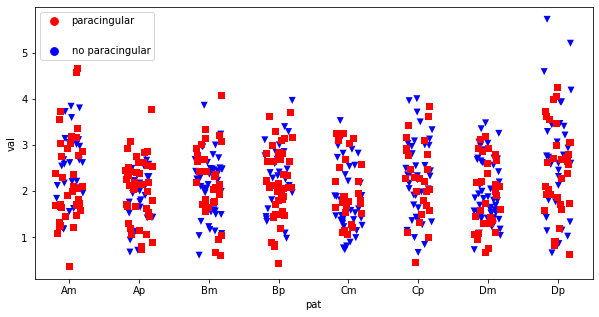

In [50]:
res_df = plot_patterns_separated(prediction_df, transformed_df)

In [51]:
def plot_patterns_separated_without_labels(transformed_df, random=False):
    # Makes local copy
    transformed_df_local = transformed_df.copy()
    full_df_local = transformed_df_local

    l = len(full_df_local)
    d = len(full_df_local.columns)
    res = pd.DataFrame(np.zeros((l,3)), index=full_df_local.index, columns=["val", "label", "pat"])
    patterns = ["Ap", "Am", "Bp", "Bm", "Cp", "Cm", "Dp", "Dm"]

    for index, row in transformed_df_local.iterrows():
        idx_nonzero = int(np.nonzero(row.values)[0])
        val_nonzero = row.iloc[idx_nonzero]
        res.loc[index, "val"] = np.abs(val_nonzero)
        res.loc[index, "label"] = 0
        if val_nonzero > 0.:
            res.loc[index, "pat"] = patterns[2*idx_nonzero]
        else:
            res.loc[index, "pat"] = patterns[2*idx_nonzero+1]

    res.sort_values(ascending=True, by='pat', inplace=True)

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    g = sns.pointplot(data=res, x=res.pat, y="val", hue = "label", alpha=[0.5,0.5], palette=['blue', 'red'], markers=['v', 's'], scale=2, linestyles=['None', 'None'], ax=ax)
    plt.setp(g.collections, alpha=0.5)
    # plt.setp(g.lines, alpha=.5) 
    sns.stripplot(data=res[res.label==0], x=res.pat, y="val", hue = "label", marker='v', palette=['blue'], jitter=.1, ax=ax)
    # sns.stripplot(data=res[res.label==1], x=res.pat, y="val", hue = "label", marker='s', palette=['red'], jitter=.1, ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([],[], frameon=False)
    
    plt.show()

    return res

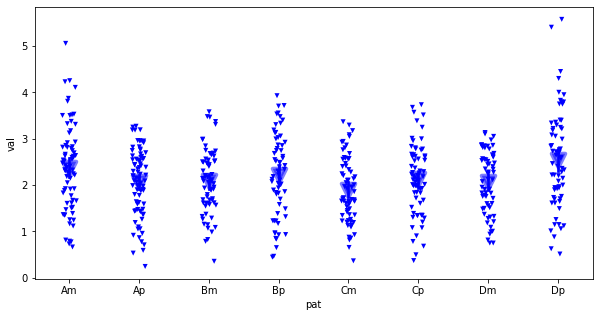

In [52]:
res_train_df = plot_patterns_separated_without_labels(transformed_train_df)

In [53]:
def plotting_hist(res_df):
    patterns = ["Am", "Ap", "Bm", "Bp", "Cm", "Cp", "Dm", "Dp"]

    plt.rc('axes', labelsize=14) 
    f, axs = plt.subplots(4, 2, figsize=(11, 22))

    for i, pat in enumerate(patterns):
        axs[i%4,int(i/4)].hist(res_df[(res_df.label==0) & (res_df.pat==pat)].val, alpha=0.5)
        axs[i%4,int(i/4)].hist(res_df[(res_df.label==1) & (res_df.pat==pat)].val, alpha=0.5)

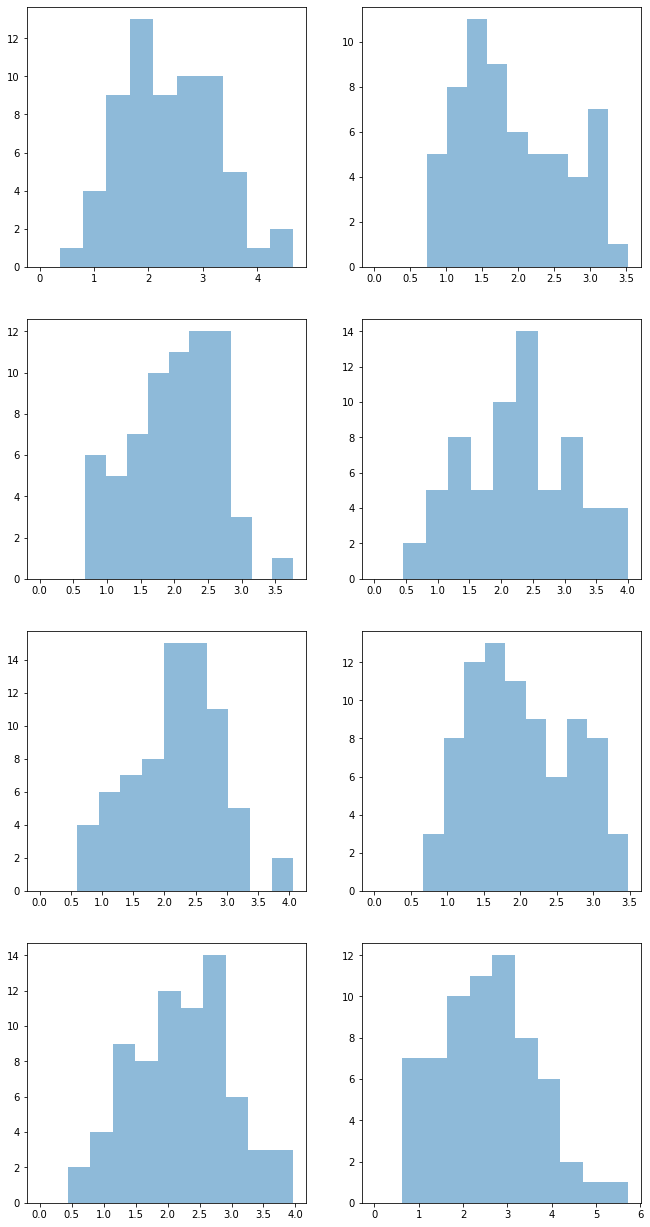

In [54]:
res0_df = res_df.copy()
res0_df.label=0
plotting_hist(res0_df)

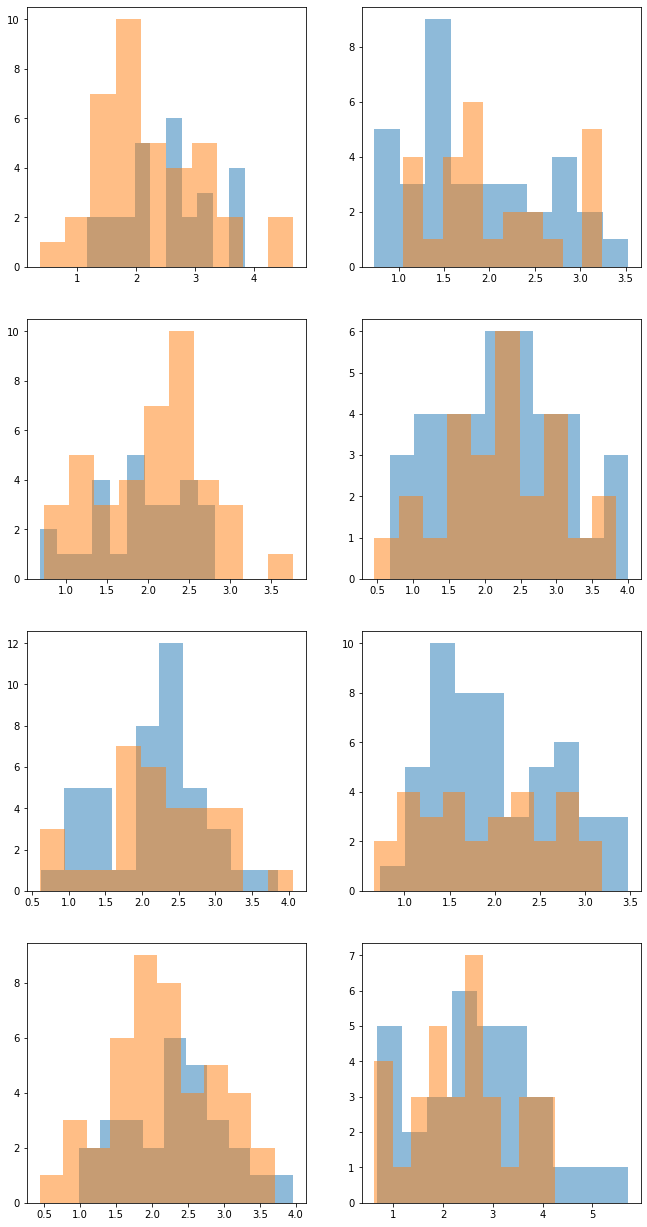

In [55]:
plotting_hist(res_df)

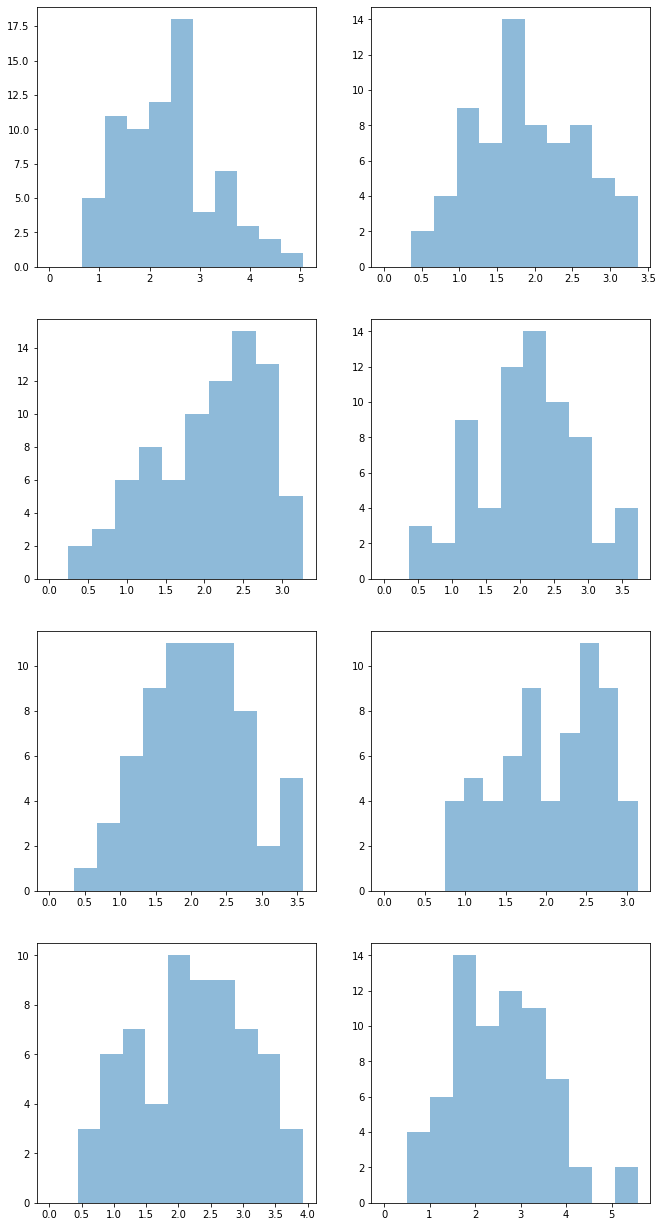

In [56]:
plotting_hist(res_train_df)

Mean label = 0.48816029143898


array([0.59375   , 0.59701493, 0.42465753, 0.61111111, 0.42622951,
       0.4       , 0.36585366, 0.50769231])

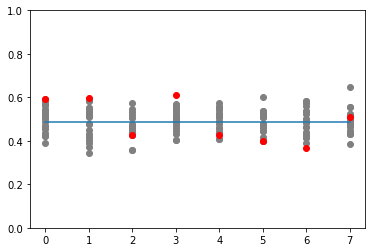

In [57]:
plot_predictions(prediction_df, transformed_df)

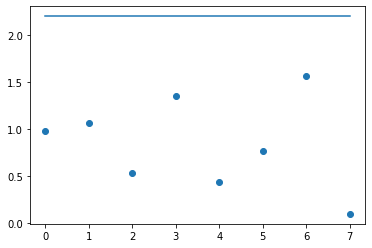

In [58]:
res_p = do_t_test(prediction_df, transformed_df, nb_components=4)

(0, 0.0, 0, 0)

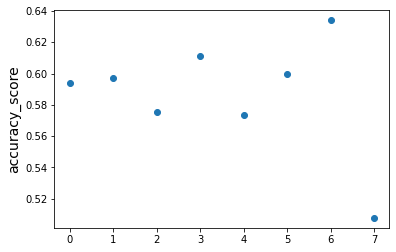

In [59]:
give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, nb_components=4)

## Visualize umap

In [60]:
def compute_umap(df):
    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [61]:
def display_umaps_true_labels(visual_embs_train, reducer, test_df, prediction_df, verbose=False):
    if verbose:
        print("Test df:")
        print(test_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    if verbose:
        print("UMAP embeddings")
        print(visual_embs_train.shape)
        print(visual_embs_train[:5])
    visual_embs_test = reducer.transform(test_df)

    ## plot the graphs

    plt.figure()
    plt.scatter(visual_embs_train[:,0], visual_embs_train[:,1], c='green', alpha=0.1)

    # plot for true labels
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs_test[:,0], visual_embs_test[:,1], c=colors, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    plt.show()

    return pd.DataFrame(visual_embs_test, index=test_df.index.values)

In [62]:
visual_embs, reducer = compute_umap(test_df)

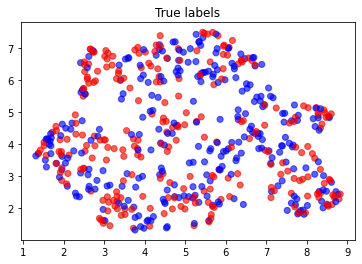

In [63]:
df_umap = display_umaps_true_labels(visual_embs, reducer, test_df, prediction_df, verbose=False)

In [64]:
transformed_df.head()

,trans_0,trans_1,trans_2,trans_3
ID,,,,
100307,0.0000,2.315576,0.0,0.0
100610,0.0000,-2.062740,0.0,0.0
101107,0.0000,2.342688,0.0,0.0
101309,0.0000,3.160149,0.0,0.0
102008,0.7972,0.000000,0.0,0.0


In [65]:
transformed_df2 = transformed_df.copy()

In [66]:
transformed_df2["label"] = transformed_df.trans_2.apply(lambda x: 1 if x > 0. else 0)

In [67]:
transformed_df2.head()

,trans_0,trans_1,trans_2,trans_3,label
ID,,,,,
100307,0.0000,2.315576,0.0,0.0,0
100610,0.0000,-2.062740,0.0,0.0,0
101107,0.0000,2.342688,0.0,0.0,0
101309,0.0000,3.160149,0.0,0.0,0
102008,0.7972,0.000000,0.0,0.0,0


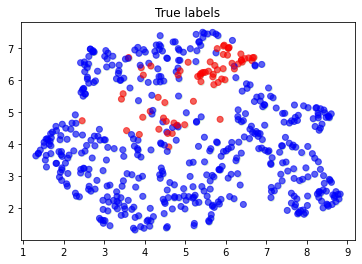

In [68]:
df_umap = display_umaps_true_labels(visual_embs, reducer, test_df, transformed_df2, verbose=False)

## Correspondance des sujets ACCpatterns

In [69]:
transformed_df2[transformed_df2.label==1].index

Int64Index([103212, 105620, 111312, 113316, 114318, 114924, 115017, 118225,
            121719, 122418, 123420, 129028, 131924, 137633, 143325, 150423,
            151021, 154431, 165941, 169545, 169747, 173233, 177645, 182840,
            186848, 189349, 198653, 206525, 208226, 209228, 211821, 211922,
            212419, 213421, 214524, 286650, 298051, 303624, 329844, 361234,
            436845, 463040, 499566, 513130, 517239, 576255, 578158, 580650,
            586460, 598568, 634748, 667056, 751550, 753251, 792867, 828862,
            833148, 869472, 871762, 872158, 877269, 882161, 887373, 930449,
            973770],
           dtype='int64', name='ID')

In [70]:
transformed_df2[transformed_df2.label==1]

,trans_0,trans_1,trans_2,trans_3,label
ID,,,,,
103212,0.0,0.0,0.994999,0.0,1
105620,0.0,0.0,3.035072,0.0,1
111312,0.0,0.0,3.712364,0.0,1
113316,0.0,0.0,2.473231,0.0,1
114318,0.0,0.0,2.555761,0.0,1
...,...,...,...,...,...
877269,0.0,0.0,1.640028,0.0,1
882161,0.0,0.0,2.811415,0.0,1
887373,0.0,0.0,2.548732,0.0,1


In [71]:
prediction_df[transformed_df2.label==1]

,label,predicted_0,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6,predicted_7,predicted_8,...,predicted_243,predicted_244,predicted_245,predicted_246,predicted_247,predicted_248,predicted_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
103212,1,0.485120,0.472673,0.488579,0.479709,0.473322,0.472091,0.500000,0.488885,0.491342,...,0.490520,0.484303,0.489630,0.500000,0.486998,0.485802,0.485934,0.483323,0.482484,0.485715
105620,0,0.489922,0.492495,0.489471,0.488663,0.485721,0.492279,0.488973,0.490079,0.489956,...,0.489677,0.493308,0.489823,0.489487,0.489614,0.490375,0.491913,0.489650,0.489517,0.491695
111312,0,0.471450,0.417118,0.486037,0.454296,0.438288,0.415553,0.516194,0.485483,0.500000,...,0.492925,0.458722,0.489081,0.521016,0.479544,0.472783,0.468920,0.464286,0.462296,0.468699
113316,1,0.480108,0.452091,0.487648,0.470374,0.460418,0.451135,0.500000,0.487639,0.492790,...,0.491401,0.474910,0.489429,0.506230,0.484266,0.481029,0.479694,0.476205,0.475019,0.479474
114318,0,0.500000,0.540428,0.491627,0.510334,0.515749,0.541098,0.471912,0.492965,0.486605,...,0.487639,0.515089,0.490288,0.469728,0.500000,0.500000,0.506376,0.506134,0.506712,0.506161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877269,0,0.456252,0.472258,0.460370,0.440499,0.455395,0.433221,0.455010,0.469008,0.448044,...,0.472623,0.458619,0.478203,0.437262,0.462794,0.455917,0.480676,0.445928,0.445984,0.450273
882161,0,0.449075,0.468671,0.454268,0.430570,0.448881,0.421906,0.448348,0.464626,0.439625,...,0.469316,0.451905,0.476186,0.424859,0.457858,0.448618,0.479100,0.436968,0.437292,0.441758
887373,0,0.455188,0.471727,0.459466,0.439024,0.454429,0.431539,0.454022,0.468359,0.446795,...,0.472133,0.457624,0.477905,0.435418,0.462063,0.454835,0.480443,0.444614,0.444690,0.449010


In [72]:
prediction_df[transformed_df2.trans_1 > 0.]

,label,predicted_0,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6,predicted_7,predicted_8,...,predicted_243,predicted_244,predicted_245,predicted_246,predicted_247,predicted_248,predicted_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
100307,0,0.518107,0.608458,0.494703,0.541186,0.558439,0.610391,0.447737,0.500000,0.481827,...,0.484733,0.546079,0.490953,0.441781,0.500000,0.517211,0.526988,0.530140,0.531179,0.526778
101107,1,0.500000,0.551338,0.492119,0.515282,0.522602,0.552208,0.468025,0.493624,0.485840,...,0.487174,0.520060,0.490395,0.465228,0.500000,0.500000,0.509679,0.509841,0.510477,0.509465
101309,1,0.516081,0.600118,0.494326,0.537418,0.553228,0.601894,0.450680,0.500000,0.482412,...,0.485088,0.542294,0.490871,0.445178,0.500000,0.515282,0.524468,0.527253,0.528197,0.524257
102614,1,0.500000,0.538346,0.491533,0.509390,0.514441,0.538977,0.472654,0.492839,0.486751,...,0.487728,0.514140,0.490268,0.470587,0.500000,0.500000,0.505746,0.505356,0.505992,0.505531
106016,0,0.520707,0.619189,0.500000,0.546020,0.565122,0.621328,0.443968,0.500000,0.481077,...,0.484276,0.550935,0.491057,0.437434,0.506386,0.519687,0.530222,0.533844,0.535032,0.530012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770352,0,0.534361,0.511052,0.526643,0.549604,0.526302,0.558293,0.527534,0.516445,0.540082,...,0.508374,0.531596,0.500000,0.573963,0.516342,0.535363,0.500000,0.542570,0.541999,0.543245
810439,1,0.539915,0.513816,0.531358,0.557360,0.531350,0.567185,0.532696,0.519822,0.546626,...,0.510921,0.536786,0.500000,0.583673,0.520157,0.541011,0.500000,0.549249,0.548801,0.549851
814649,1,0.528239,0.508008,0.521445,0.541053,0.520738,0.548490,0.521844,0.512723,0.532867,...,0.505568,0.525876,0.500000,0.563268,0.512139,0.529137,0.500000,0.534955,0.534474,0.535962
